<a href="https://colab.research.google.com/github/kuzhuppillil/Current_Project/blob/main/ValueInvestor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mplfinance as mpf
import re


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Flatten


In [3]:
pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 875.2 kB/s eta 0:00:00


In [5]:
#reading and saving each stock data into a dictionary
file_path = "/content/drive/Othercomputers/My Laptop/Apziva Projects/ValueInvestor/2020Q1Q2Q3Q4-2021Q1.xlsx"

sheets = pd.ExcelFile(file_path)

df_dic = {}

for sheet_name in sheets.sheet_names:
  df = pd.read_excel(file_path,sheet_name = sheet_name, index_col="Date", parse_dates=["Date"])
  df_dic[sheet_name] = df

In [6]:
#loading each stock datasets into individual dfs
df_rus = df_dic['Russia - Sberbank Rossii PAO (S']

In [7]:
df_rus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, 2021-03-31 00:00:00 to Highest: 296.07
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     312 non-null    object 
 1   Open      312 non-null    object 
 2   High      312 non-null    object 
 3   Low       312 non-null    object 
 4   Vol.      311 non-null    object 
 5   Change %  311 non-null    float64
dtypes: float64(1), object(5)
memory usage: 17.1+ KB


In [8]:
df_rus.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043
2020-01-03 00:00:00,255,255.99,258.19,253.7,35.85M,0.0010
Highest: 296.07,Lowest: 172.15,Difference: 123.92,Average: 234.52,Change %: 14.24,NaN,NaN


In [19]:
#Removing the last row from df and making a copy
df_copy = df_rus.iloc[:-1].copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311 entries, 2021-03-31 00:00:00 to 2020-01-03 00:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    object 
 1   Open      311 non-null    object 
 2   High      311 non-null    object 
 3   Low       311 non-null    object 
 4   Vol.      311 non-null    object 
 5   Change %  311 non-null    float64
dtypes: float64(1), object(5)
memory usage: 17.0+ KB


# Preprocessing:

In [20]:
#Function to preprocess data, removing converting to float datatype and removing strings
def ini_preprocess(df):
  df['Vol.'] = df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace('-', '0').astype(float)
  df = df.astype(float)
  return df

df_copy = ini_preprocess(df_copy)

In [21]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311 entries, 2021-03-31 00:00:00 to 2020-01-03 00:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0+ KB


In [22]:
#fixing datatime index and creating an addition copy with renamed column due for compatabiliy with mplfinance libary to plot candle chart
df_copy.index = pd.to_datetime(df_copy.index)
df_copy2 = df_copy.copy()
df_copy2.rename(columns={'Price': 'Close'}, inplace=True)

# EDA:

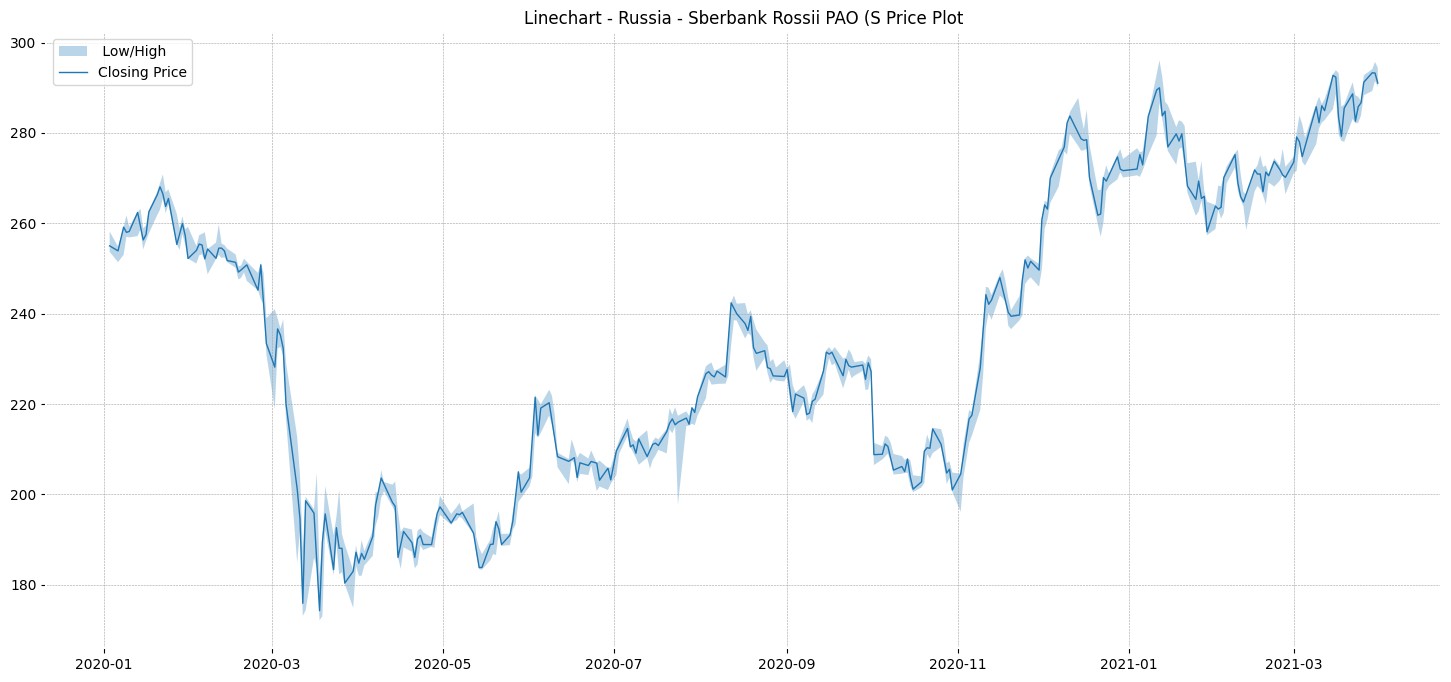

In [23]:
#Ploting linechat to vizualize the stock price variation of Russia - Sberbank Rossii PAO (S
plt.figure(figsize=(18,8))
plt.fill_between(df_copy.index, df_copy['Low'], df_copy['High'], alpha=0.3, label = " Low/High")
plt.plot(df_copy['Price'], linewidth=1, label = "Closing Price")
plt.title("Linechart - Russia - Sberbank Rossii PAO (S Price Plot")
plt.legend()
plt.show()

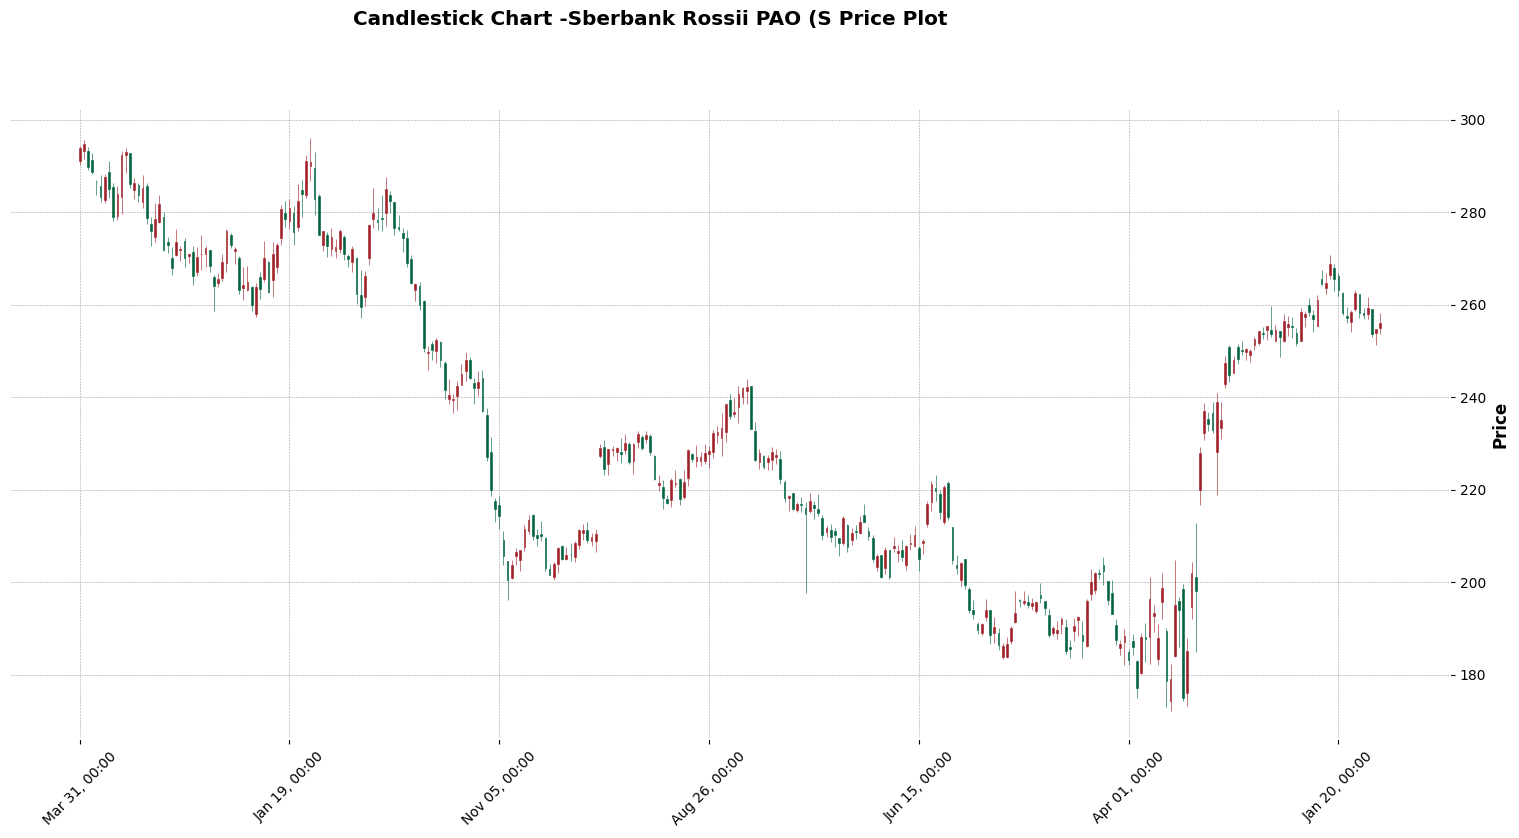

In [24]:
#Plotting candlechart using mplfinance
mpf.plot(df_copy2, type='candle', style='charles',title='Candlestick Chart -Sberbank Rossii PAO (S Price Plot', figsize = (20,9))

#Exponential Smoothing Forecast

In [68]:
def feat_engg(df):
  # #Creating moving average, window size 20 using pandas rolling function
  # df['MA'] = df['Price'].rolling(window=20).mean()

  #Forecasting price using exponential smooting
  alpha = 0.2
  df['Forecast'] = df['Price'].iloc[0]
  for i in range(1,len(df)):
    df['Forecast'].iloc[i] = alpha * df['Price'].iloc[i-1] + (1 - alpha) * df['Forecast'].iloc[i-1]

  #Finding Squared Error
  df['SE'] = (df['Price'] - df['Forecast'])**2

  return df


Exponential Smooting Forecast MSE: 67.32477320146343


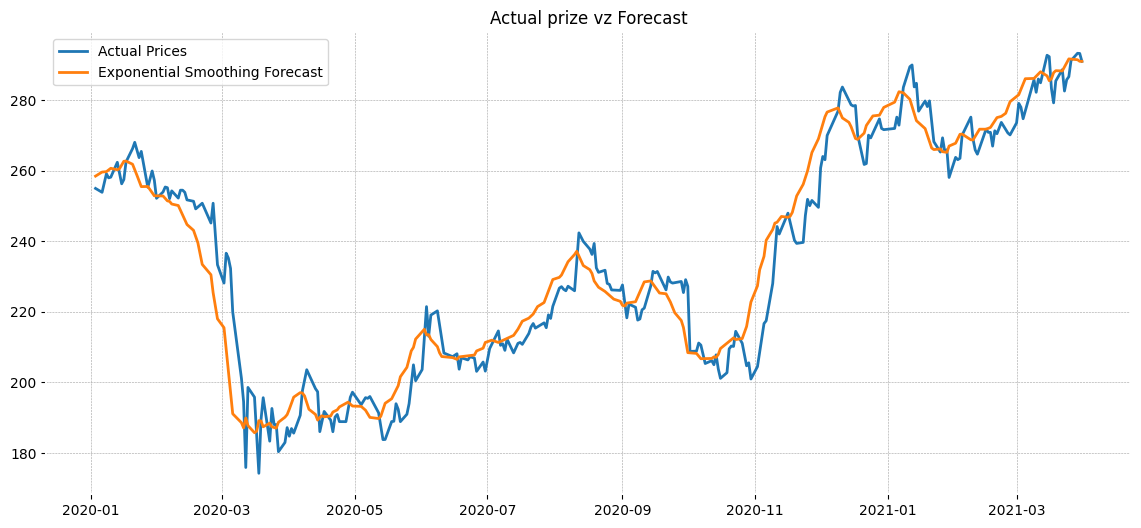

In [67]:
df_new = feat_engg(df_copy)

mse_forecast = np.mean(df_new['SE'])
print("Exponential Smooting Forecast MSE:",mse_forecast)

plt.figure(figsize = (14,6))
plt.plot(df_new.index, df_new['Price'], label='Actual Prices')
plt.plot(df_new.index, df_new['Forecast'], label='Exponential Smoothing Forecast')
plt.title('Actual prize vz Forecast')
plt.legend()
plt.show()

# Data Preprocessing for LSTM

In [53]:
#train-test split, using 2020 Q1,Q2,Q3,Q4 data for training and 2020 Q1 for test
train = df_copy.loc['2020'].copy()
test = df_copy.loc['2021'].copy()

In [71]:
test.shape

(61, 8)

In [73]:
train.shape

(250, 8)